April: **Research Questions 1.A.1** (Ideal and Real)

# Provided with upwelling-favourable wind forcing at the surface, what are the circulation patterns during an upwelling event in Mackenzie Canyon?

Circulation inside the canyon:

What is the velocity of the shelf current for the 3 upwelling cases?

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Functions

In [2]:
def plot_incoming_velocity(y_start, y_end, x_start, x_end, dep_start, dep_end,
                           umask_all, sozotaux_h, sozotaux_b, sozotaux_d):
    
    cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])
    
    xs = np.arange(umask_all.shape[-1])
    ys = np.arange(umask_all.shape[-2])
    zs = np.arange(umask_all.shape[-3])

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])
    ax1 = plt.subplot(gs[0])
    ax4 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[3])
    
    # ---------------------------

    s = ax1.pcolormesh(xs, ys, umask_all[9, :,:], cmap=cmap)
    ax1.set_aspect(aspect='equal')
    ax1.add_patch(patches.Rectangle((x_start, y_start), (x_end-x_start),(y_end-y_start), fill=False, linewidth=3))
    ax1.set_xlim([0, xs[-1]])
    ax1.set_ylim([0, ys[-1]])
    ax1.set_xlabel('Alongshore Indices', fontsize = 15)
    ax1.set_ylabel('Cross-shore Indices', fontsize = 15)
    
    # ---------------------------

    sc = ax3.pcolormesh(ys, zs, umask_all[:, :, x_start], cmap=cmap)
    ax3.add_patch(patches.Rectangle((y_start, dep_start),(y_end-y_start), dep_end-dep_start, fill=False, linewidth=3))
    ax3.set_ylim([zs[-1], 0])
    ax3.set_xlim([0, ys[-1]])
    ax3.set_ylabel('Depth Indices', fontsize = 15)
    ax3.set_xlabel('Cross-shore Indices', fontsize = 15)
    
    # ---------------------------
    
    ax4.plot(sozotaux_h, c='darkgray', lw=2, label='half')
    ax4.plot(sozotaux_b, c='dimgray', lw=2, label='base')
    ax4.plot(sozotaux_d, c='k', lw=2, label='double')
    
    ax4.legend(loc=2, ncol=3, fontsize=15)
    
    print('winds (minimum)')
    print('half: ', sozotaux_h.min())
    print('base: ', sozotaux_b.min())
    print('double: ', sozotaux_d.min())
    
    # ---------------------------
    
    ax4.set_title('Wind Stress', fontsize=20)
    ax4.set_xlabel('Time [hours]', fontsize=15)
    ax4.set_ylabel('[Nm$^{-2}$]', fontsize=20)
    ax4.set_ylim([-2.0, 1.0])
    ax4.set_xlim([0, 10*24])
    ax4.xaxis.set_ticks(np.arange(0, 10*24, 24))
    ax4.grid()
    ax4.axhline(0, linestyle='-', c='darkgoldenrod', linewidth=1.5)

    fig.tight_layout(w_pad=5.5, h_pad=3.5)
    return fig, ax2

In [3]:
def plot_incoming_velocity_ax2_A(ax2, avgU_absolute_h, avgU_absolute_b, avgU_absolute_d):
    ''' Plots unsmoothed and smoothed incoming velocities.
    '''
    avgU_absolute_smoothed_h = general_functions.smooth(avgU_absolute_h[:], 12)
    ax2.plot(avgU_absolute_h[:], c='darkgray', lw=2, alpha=0.8, linestyle='--')
    ax2.plot(avgU_absolute_smoothed_h, c='darkgray', lw=2, label='ideal half')
    
    avgU_absolute_smoothed_b = general_functions.smooth(avgU_absolute_b[:], 12)
    ax2.plot(avgU_absolute_b[:], c='dimgray', lw=2, alpha=0.8, linestyle='--')
    ax2.plot(avgU_absolute_smoothed_b, c='dimgray', lw=2, label='ideal base')
    
    avgU_absolute_smoothed_d = general_functions.smooth(avgU_absolute_d[:], 12)
    ax2.plot(avgU_absolute_d[:], c='k', lw=2, alpha=0.8, linestyle='--')
    ax2.plot(avgU_absolute_smoothed_d, c='k', lw=2, label='ideal double')
    
    ax2.legend(loc=2, ncol=5, fontsize=15)
    
    print('shelf velocities (minimum, mean)')
    print('half: ', avgU_absolute_smoothed_h.min(), np.mean(avgU_absolute_smoothed_h))
    print('base: ', avgU_absolute_smoothed_b.min(), np.mean(avgU_absolute_smoothed_b))
    print('double: ', avgU_absolute_smoothed_d.min(), np.mean(avgU_absolute_smoothed_d))
    
    ax2.set_title('Incoming Velocity (Mean and Smoothed)', fontsize=20)
    ax2.set_xlabel('Time [hours]', fontsize=15)
    ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
    #ax.yaxis.set_ticks(ticks)
    ax2.set_ylim([-0.7, 0.3])
    ax2.set_xlim([0, 10*24])
    ax2.xaxis.set_ticks(np.arange(0, 10*24, 24))
    ax2.grid()
    ax2.axhline(0, linestyle='-', c='darkgoldenrod', linewidth=1.5)
    
    return ax2

In [4]:
def plot_incoming_velocity_ax2_B(ax2, avgU_absolute, avgU_absolute_n, case):
    ''' Plots unsmoothed and smoothed incoming velocities.
    '''
    avgU_absolute_smoothed = general_functions.smooth(avgU_absolute[:], 12)
    ax2.plot(avgU_absolute[:], c='k', lw=2, alpha=0.8, linestyle='--')
    ax2.plot(avgU_absolute_smoothed, c='k', lw=2, label='canyon')
    
    avgU_absolute_smoothed_n = general_functions.smooth(avgU_absolute_n[:], 12)
    ax2.plot(avgU_absolute_n[:], c='cornflowerblue', lw=2, alpha=0.8, linestyle='--')
    ax2.plot(avgU_absolute_smoothed_n, c='cornflowerblue', lw=2, label='no canyon')
    
    ax2.legend(loc=2, ncol=5, fontsize=15)
    
    print('shelf velocities (minimum, mean)')
    print('canyon: ', avgU_absolute_smoothed.min(), np.mean(avgU_absolute_smoothed))
    print('no canyon: ', avgU_absolute_smoothed_n.min(), np.mean(avgU_absolute_smoothed_n))
    
    ax2.set_title(case+' - Incoming Velocity (Canyon and No-Canyon)', fontsize=20)
    ax2.set_xlabel('Time [hours]', fontsize=15)
    ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
    ax2.set_ylim([-0.7, 0.3])
    ax2.set_xlim([0, 10*24])
    ax2.xaxis.set_ticks(np.arange(0, 10*24, 24))
    ax2.grid()
    ax2.axhline(0, linestyle='-', c='darkgoldenrod', linewidth=1.5)
    
    return ax2

# Ideal

In [5]:
x_start = 200
x_end = 230
y_start = 45
y_end = 190
dep_start = 2
dep_end = 6 #changed from 5

fname = "1_MCKNZ_1h_20170101_201701*"
meshmaskname = '1_mesh_mask.nc'
flag = 'U'

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_half/'
vozocrtx_h, umask_h, umask_all_h, depthu_h, e1u, e2u, sozotaux_h = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_h, avgU_all_depths_h, avgU_box_depths_h, avgU_absolute_h = quicklook.calculate_avg_vel(vozocrtx_h, dep_start, dep_end)

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
vozocrtx_b, umask_b, umask_all_b, depthu_b, e1u, e2u, sozotaux_b = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_b, avgU_all_depths_b, avgU_box_depths_b, avgU_absolute_b = quicklook.calculate_avg_vel(vozocrtx_b, dep_start, dep_end)

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_double/'
vozocrtx_d, umask_d, umask_all_d, depthu_d, e1u, e2u, sozotaux_d = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_d, avgU_all_depths_d, avgU_box_depths_d, avgU_absolute_d = quicklook.calculate_avg_vel(vozocrtx_d, dep_start, dep_end)

In [7]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_nocanyon_half/'
vozocrtx_nh, umask_nh, umask_all_nh, depthu_nh, e1u, e2u, sozotaux_nh = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_nh, avgU_all_depths_nh, avgU_box_depths_nh, avgU_absolute_nh = quicklook.calculate_avg_vel(vozocrtx_nh, dep_start, dep_end)

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_nocanyon_base/'
vozocrtx_nb, umask_nb, umask_all_nb, depthu_nb, e1u, e2u, sozotaux_nb = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_nb, avgU_all_depths_nb, avgU_box_depths_nb, avgU_absolute_nb = quicklook.calculate_avg_vel(vozocrtx_nb, dep_start, dep_end)

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_nocanyon_double/'
vozocrtx_nd, umask_nd, umask_all_nd, depthu_nd, e1u, e2u, sozotaux_nd = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_nd, avgU_all_depths_nd, avgU_box_depths_nd, avgU_absolute_nd = quicklook.calculate_avg_vel(vozocrtx_nd, dep_start, dep_end)

winds (minimum)
half:  -0.425345
base:  -0.85069
double:  -1.70138
shelf velocities (minimum, mean)
half:  -0.119101123277 -0.0847778445144
base:  -0.222637961862 -0.132317227751
double:  -0.351352774352 -0.206192354785


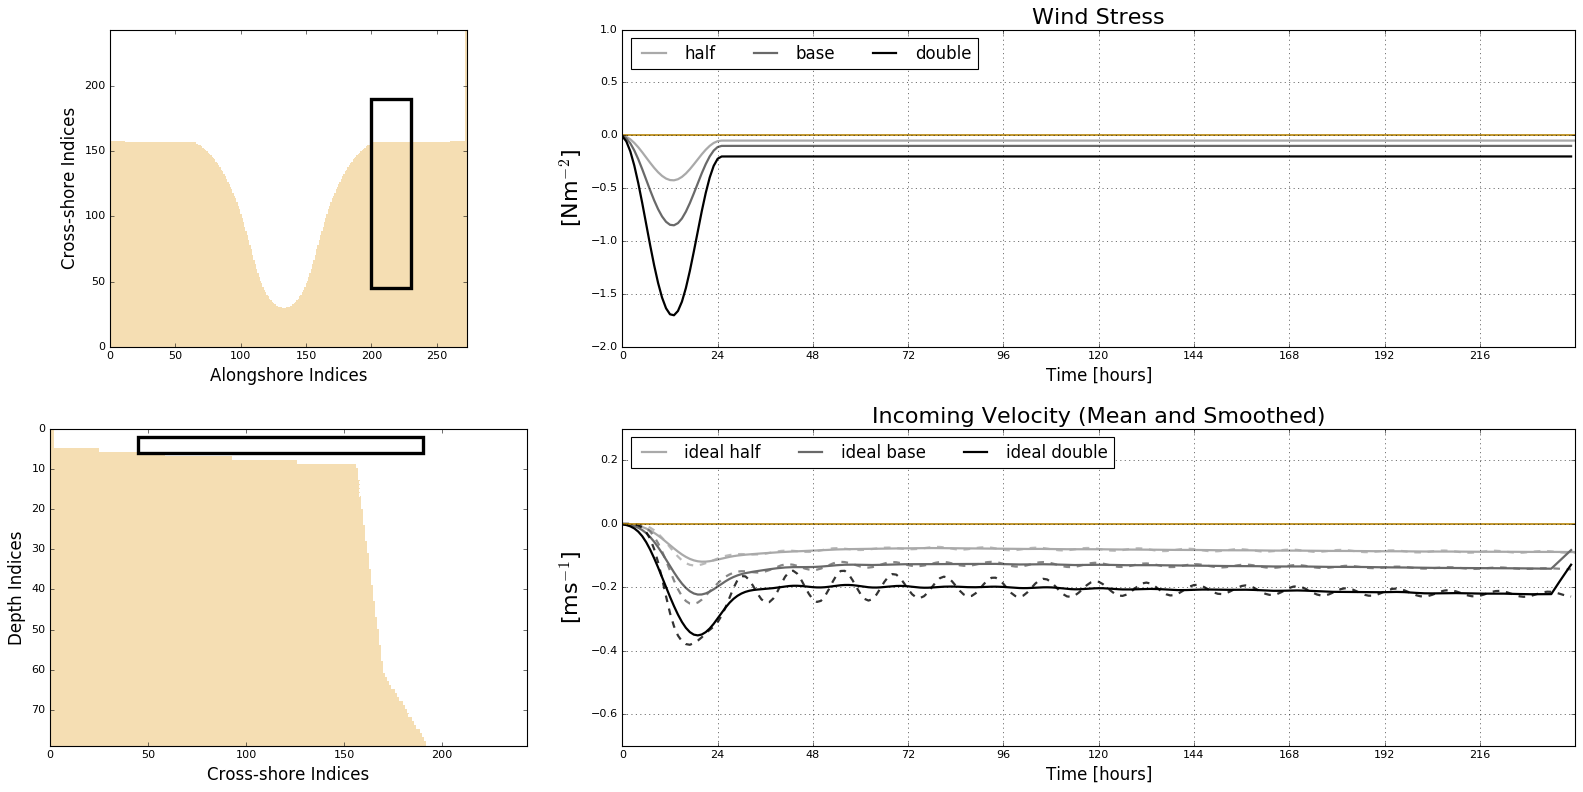

In [12]:
fig, ax2 = plot_incoming_velocity(y_start, y_end, x_start, x_end, dep_start, dep_end,
                                  umask_all_h, sozotaux_h, sozotaux_b, sozotaux_d)
ax2 = plot_incoming_velocity_ax2_A(ax2, avgU_absolute_h, avgU_absolute_b, avgU_absolute_d)

fig.savefig('../writing_images/shelf_currents_ideal_fig1.png', dpi=100, bbox_inches='tight')

# Real

In [16]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_half/'
vozocrtx_h, umask_h, umask_all_h, depthu_h, e1u, e2u, sozotaux_h = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_h, avgU_all_depths_h, avgU_box_depths_h, avgU_absolute_h = quicklook.calculate_avg_vel(vozocrtx_h, dep_start, dep_end)

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/'
vozocrtx_b, umask_b, umask_all_b, depthu_b, e1u, e2u, sozotaux_b = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_b, avgU_all_depths_b, avgU_box_depths_b, avgU_absolute_b = quicklook.calculate_avg_vel(vozocrtx_b, dep_start, dep_end)

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_double/'
vozocrtx_d, umask_d, umask_all_d, depthu_d, e1u, e2u, sozotaux_d = quicklook.get_vars_for_box(dirname, fname, meshmaskname, x_start, x_end, y_start, y_end, flag)
avgU_all_ys_d, avgU_all_depths_d, avgU_box_depths_d, avgU_absolute_d = quicklook.calculate_avg_vel(vozocrtx_d, dep_start, dep_end)

winds (minimum)
half:  -0.425345
base:  -0.85069
double:  -1.70138
shelf velocities (minimum, mean)
half:  -0.0812775568899 -0.0666140672088
base:  -0.133490962508 -0.113173338624
double:  -0.206546395865 -0.177083238516


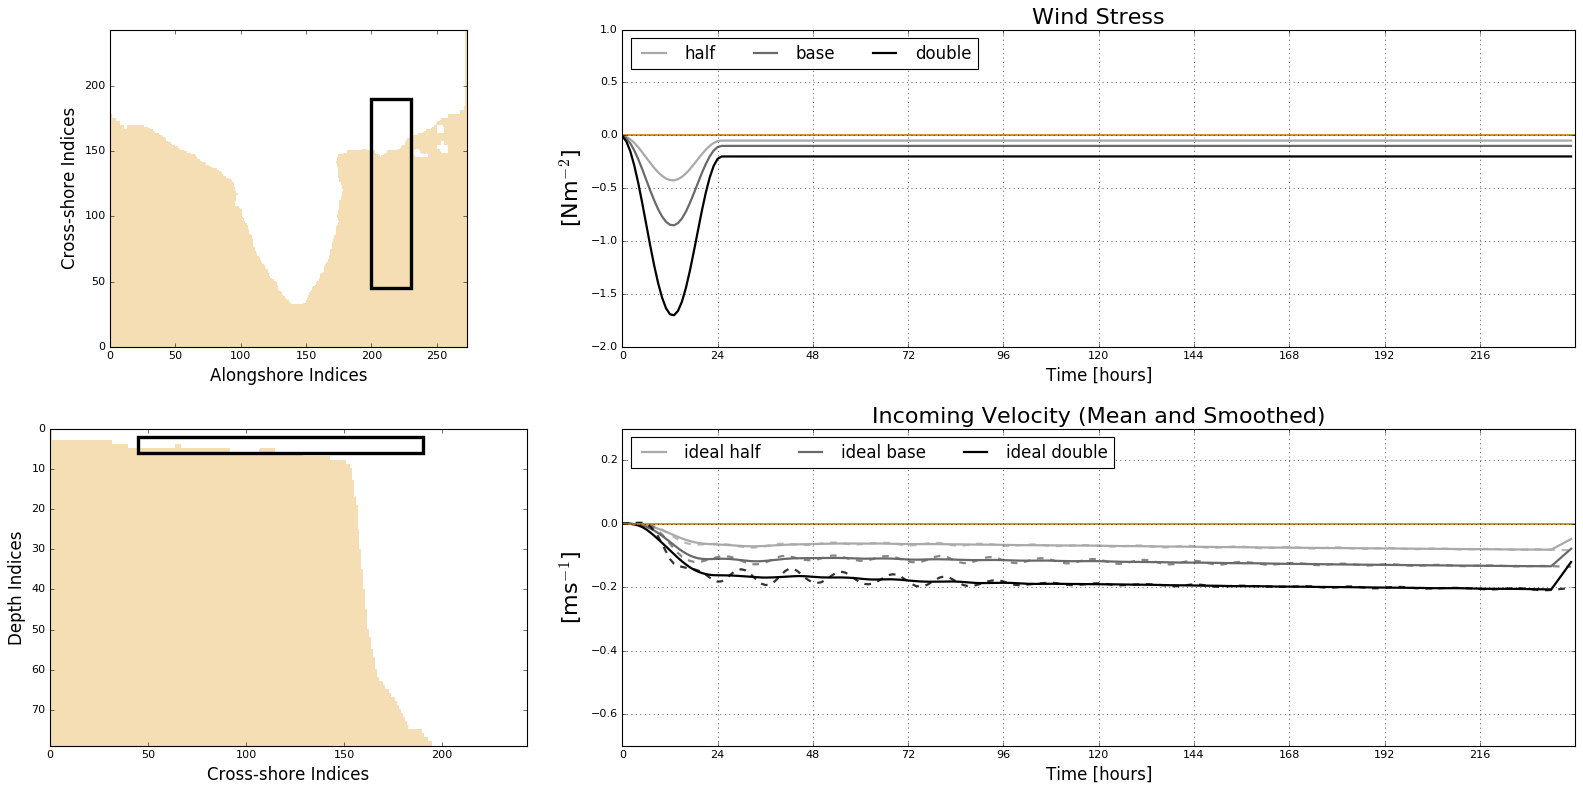

In [17]:
fig, ax2 = plot_incoming_velocity(y_start, y_end, x_start, x_end, dep_start, dep_end,
                                  umask_all_h, sozotaux_h, sozotaux_b, sozotaux_d)
ax2 = plot_incoming_velocity_ax2_A(ax2, avgU_absolute_h, avgU_absolute_b, avgU_absolute_d)

fig.savefig('../writing_images/shelf_currents_real_fig1.png', dpi=100, bbox_inches='tight')